# K-means

## 0. 简介

K-means即K-均值聚类，是一种__无监督学习__方法，其目标为将目标数据分割到预设的K个聚类中。

启发式地，K-means的步骤可被描述为：
1. 初始化K个聚类中心，并定义K个聚类；
2. 迭代。首先求数据点与聚类中心的距离，将数据点归入距离最近的聚类中心的聚类中。随后重新估计K个聚类中心，聚类中心即数据点的重心。
当聚类中心不再移动时停止迭代。

K-means的优化模型描述如下。对于给定数据集$\{x_i\}_{i=1}^n$与聚类$\{C_i\}_{i=1}^K$我们希望某一聚类内元素与聚类中心的误差最小。用最小二乘误差表示如下：

$$
arg\min_{C,\mu} \sum_{i=1}^K \sum_{x_j{\in}C_i}||x_j-\mu_i||_2^2
$$

该优化模型的求解是NP难的。类似于EM算法，迭代地优化C与$\mu$。首先初始化K个聚类中心，随后交替固定${\mu}$优化C与固定C优化${\mu}$，即与上述K-means启发式的步骤相同。由于每一步目标函数单调减小，但显然不一定取得全局最优值。

若将最小二乘误差（2范数的平方）改为1范数或其他距离定义，也可构建K-means模型。其中1范数所实现的模型称K-medoid模型。

## 1. K-means的实现

__实验环境__: Red Hat 6.4, Python 3.6.5 (Anaconda), Jupyter

此实现中预设了三种距离，即1范数、2范数与无穷范数。

In [51]:
import math, numpy as np
from numpy import random

def kmeans(X, k, tp='2LP') :
    THRESHOLD = 1E-5
    newMu = [random.uniform(min(dim), max(dim), k) for dim in X]; mu = np.zeros([len(X)-1, k])
    groups = [0]*len(X[0])
    rounds = 0
    while max([dist([dim[i] for dim in mu],[dim[i] for dim in newMu], tp) for i in range(k)]) > THRESHOLD :
        minDists = [float('inf')]*len(X[0])
        for i in range(len(X[0])) :
            for j in range(k) :
                d = dist([dim[i] for dim in X], [dim[j] for dim in newMu], tp)
                if d < minDists[i] :
                    minDists[i] = d
                    groups[i] = j
        mu = newMu
        newMu = [[np.mean([dim[m] for m in range(len(X[0])) if groups[m] == j]) for j in range(k)] for dim in X]
        rounds+= 1
    return newMu, groups, rounds

def dist(X, Y, tp='2LP') :
    if tp == '1LP' :
        return sum([abs(i-j) for i,j in zip(X,Y)])
    elif tp == '2LP' :
        return math.sqrt(sum([(i-j)**2 for i,j in zip(X,Y)]))
    elif tp == 'InfLP' :
        return max([abs(i-j) for i,j in zip(X,Y)])
    else :
        return -1

## 2. 在自定义数据集上测试

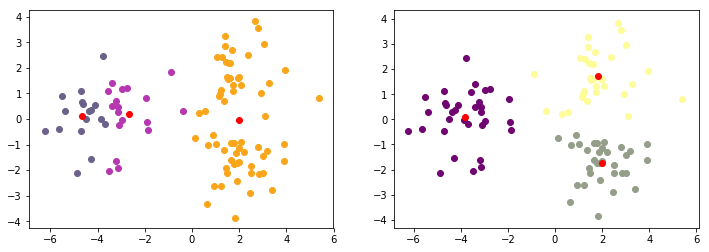

In [61]:
%matplotlib inline
from matplotlib import pyplot as plt
from numpy import random

# Uniformly generate random points
SIZE = 100
X = list(random.randn(SIZE//3) + 2) + list(random.randn(SIZE//3) + 2) + list(random.randn(SIZE//3) - 4)
Y = list(random.randn(SIZE//3) + 2) + list(random.randn(SIZE//3) - 2) + list(random.randn(SIZE//3))

plt.figure(figsize=(12,4))
for i in range(2) :
    # k-means
    GROUPS = 3
    mu, groups, _ = kmeans([X, Y], GROUPS, '2LP')

    # Scatter
    plt.subplot(1,2,i+1)
    for j in range(GROUPS) :
        plt.scatter([p for i,p in enumerate(X) if groups[i] == j], [p for i,p in enumerate(Y) if groups[i] == j], \
                    c=random.rand(3))
    _ = plt.scatter(mu[0], mu[1], c='red')

使用自定义数据集测试该算法。此数据集由3个均值不同而方差相同的__高斯分布__生成。K-means聚类中心数为3。对于相同的数据集，右图所示的聚类成功地区分了3组生成数据，而左侧的聚类则没有。说明了K-means并__不能取得全局最优__，且该算法的表现是__不稳定__的。

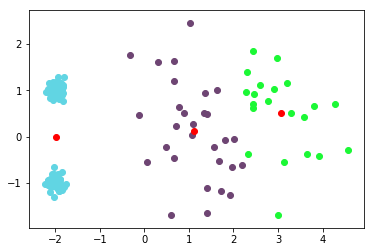

In [65]:
# Generate random points of different variances
SIZE = 100
X = list(random.normal(size=SIZE//2, loc=2)) + list(random.normal(size=SIZE//2, loc=-2, scale=0.1)) + list(random.normal(size=SIZE//2, loc=-2, scale=0.1))
Y = list(random.normal(size=SIZE//2)) + list(random.normal(size=SIZE//2, loc=1, scale=0.1)) + list(random.normal(size=SIZE//2, loc=-1, scale=0.1))

plt.figure(figsize=(6,4))
# k-means
GROUPS = 3
mu, groups, _ = kmeans([X, Y], GROUPS, '1LP')

# Scatter
for j in range(GROUPS) :
    plt.scatter([p for i,p in enumerate(X) if groups[i] == j], [p for i,p in enumerate(Y) if groups[i] == j], \
                c=random.rand(3))
_ = plt.scatter(mu[0], mu[1], c='red')

若不同数据生成分布的__方差不同__，则会加剧由于初始聚类中心随机性带来的错误聚类。上述数据点仍为3个均值不同的高斯分布生成，但其中2给数据集方差明显小于另一数据集。K-means算法倾向于将上图左侧两个方差小的组聚为一类，而分割右侧方差较大的组。这反映了K-means算法的一般性问题：__方差较大的聚类对于目标函数的贡献较大__，因而算法会倾向于将小的组合并，而分割大的组以补偿合并带来的方差增加。

生成式模型则可解决这一问题。若仍然希望使用K-means，如上述代码所示，将距离改为__1范数__可降低错误分类的概率，但无法从根本上解决问题。

K-means算法将会收敛。我们以迭代次数为标准考察样本量增加对于收敛速度的影响：

Text(0,0.5,'Iteration rounds')

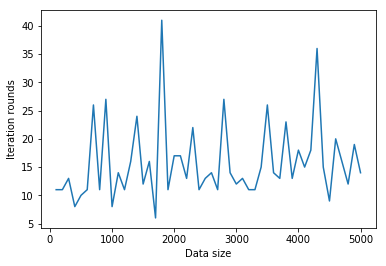

In [77]:
rList = []
for SIZE in range(100,5001,100) :
    X = list(random.normal(size=SIZE//2, loc=2)) + list(random.normal(size=SIZE//2, loc=-2)) + list(random.normal(size=SIZE//2, loc=-2))
    Y = list(random.normal(size=SIZE//2)) + list(random.normal(size=SIZE//2, loc=1)) + list(random.normal(size=SIZE//2, loc=-1))

    GROUPS = 3
    _, _, rounds = kmeans([X, Y], GROUPS, '2LP')
    rList.append(rounds)
plt.plot(range(100, 5001, 100), rList)
plt.xlabel('Data size'); plt.ylabel('Iteration rounds')

我们将测试数据集大小从100增加到5000。如上图所示，收敛发生的迭代轮数与数据集大小并__无显著的相关性__。对于大多数数据，K-means均可在20轮以下收敛，但有些情况迭代轮数可高达40。迭代次数基本是__随机的__，可能依赖于数据集的生成与初始聚类点的位置。

## 3. 在UCI鸢尾花数据集上测试K-means

/home/LYJ/usr/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Accuracy of iris categorization by k-means: 0.8866666666666667


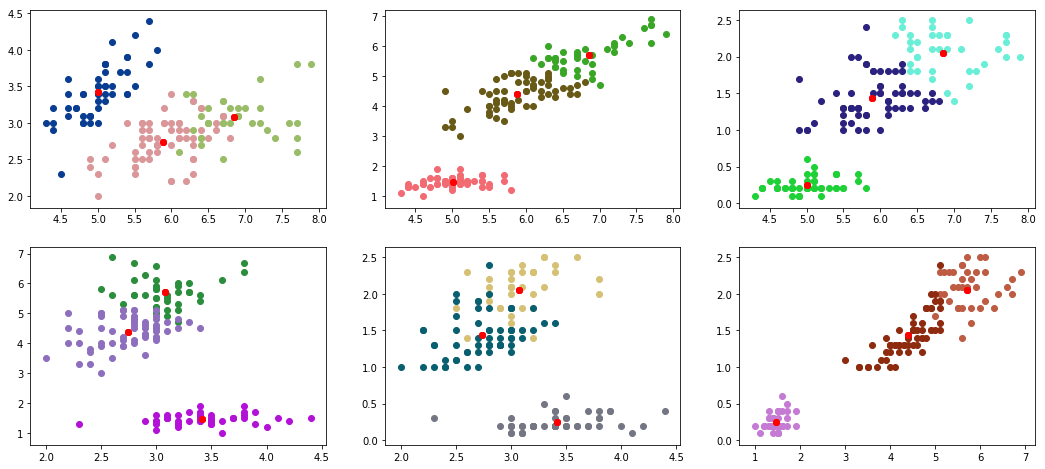

In [98]:
# Using UCI database iris

# read data
labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
FEATURES = 4; GROUPS = 3
fi = open('../databases/iris/iris.data')
X = []; tags = []
for i in range(FEATURES) :
    X.append([])
for line in fi :
    tmp = line.split(',')
    for i in range(FEATURES) :
        X[i].append(float(tmp[i]))
    tags.append(labels.index(tmp[FEATURES].strip()))

# kmeans
mu, groups, _ = kmeans(X, GROUPS, '2LP')

# Scatter
plt.figure(figsize=(18, 8))
pair = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
for k,p in enumerate(pair) :
    for j in range(GROUPS) :
        plt.subplot(2,3,k+1)
        plt.scatter([p for i,p in enumerate(X[p[0]]) if groups[i] == j], [p for i,p in enumerate(X[p[1]]) if groups[i] == j], \
                    c=random.rand(3))
        plt.scatter(mu[p[0]], mu[p[1]], c='red')

# scoring
score = 0
for i in range(GROUPS) :
    tmp = sum([groups[j] == (tags[j]+i)%GROUPS for j in range(len(tags))])
    if tmp > score :
        score = tmp
print('Accuracy of iris categorization by k-means:', score/len(tags))

由于K-means算法的不稳定性，该算法在鸢尾花数据集上聚类的正确性在约__40%在89%之间波动__。以上聚类对于鸢尾花正确分类的比率为88.7%。当然，由于聚类后的3个鸢尾花的种类并不能和原数据集的标签匹配，此处的正确率取所有匹配方式中正确率最高的。

由于数据集中共有4种特征，我们对于其中每两个特征为坐标表现出聚类情况。可见3个鸢尾花种类中的2个在多个特性上相似性较高，无法完全区分。